## PSI (Population Stability Index)

Population Stability Index (PSI) compares the distribution of predicted probability in scoring data with predicted probability in training data.  
The idea is to check “How different the current scored data is, compared to the training data”.

$$
PSI = \sum_{i=1}^{k} \left( (O_i - E_i) \times \ln\left(\frac{O_i}{E_i}\right) \right)
$$

In [53]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, udf
import pyspark.sql.functions as F
from pyspark.sql.types import LongType
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Population Stability Index") \
    .getOrCreate()

In [54]:
generate_random_score = udf(lambda: np.random.randint(0, 1001), LongType())

# Generate sample data
def generate_data():
    dev_data = spark.range(1000).alias("id") \
    .withColumn("score", generate_random_score())

    val_data = spark.range(1000).alias("id") \
    .withColumn("score", generate_random_score())

    return dev_data, val_data

def export_to_xslx(dev_data, val_data):
    with pd.ExcelWriter("data.xlsx", engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        # Save dev_data to "dev" sheet
        dev_data.toPandas().sort_values('score')['score'].to_excel(writer, sheet_name="dev", index=False)
        
        # Save val_data to "val" sheet
        val_data.toPandas().sort_values('score')['score'].to_excel(writer, sheet_name="val", index=False)

# Define function for calculating PSI
def population_stability_index(dev_data, val_data, col_name):
    # Define bins
    bins = [i for i in range(100, 1100, 100)]
    # bins = np.linspace(
    #     dev_data.agg({col_name: "min"}).collect()[0][0],
    #     dev_data.agg({col_name: "max"}).collect()[0][0],
    #     num=10 + 1
    # )

    # Apply binning
    dev_data = dev_data \
        .withColumn("bin", (col(col_name) / 100) \
        .cast("int") * 100)

    val_data = val_data \
            .withColumn("bin", (col(col_name) / 100)
            .cast("int") * 100)

    dev_counts = dev_data.groupBy("bin").agg(count("*").alias("dev_count"))
    val_counts = val_data.groupBy("bin").agg(count("*").alias("val_count"))
    merged_counts = dev_counts.join(val_counts, "bin", "left")

    merged_counts = merged_counts \
    .withColumn("dev_pct", (col("dev_count") / dev_data.count()))
    merged_counts = merged_counts \
    .withColumn("val_pct", (col("val_count") / val_data.count()))

   # Calculate PSI
    merged_counts = merged_counts.withColumn(
        "psi",
        (col("val_pct") - col("dev_pct")) *
        F.log(col("val_pct") / col("dev_pct")),
    )
    psi_value = merged_counts \
    .selectExpr("sum(psi) as psi_value") \
    .collect()[0]["psi_value"]

    return psi_value, merged_counts


def plot_psi(plot_data, psi_value):
    df = plot_data.toPandas().sort_values(by='bin', ascending=True)

    # Plotagem
    plt.figure(figsize=(10, 6))

    # Definindo a largura da barra
    bar_width = 0.35

    # Criando o índice para as barras
    index = np.arange(len(df))

    # Plotando as barras para dev_count e val_count lado a lado
    bars1 = plt.bar(index, df['dev_count'], bar_width, label='Dev Count')
    bars2 = plt.bar(index + bar_width, df['val_count'], bar_width, label='Val Count')

    # Adicionando a contagem acima de cada barra
    for bars in [bars1, bars2]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 2, int(yval), ha='center', va='bottom')

    plt.xlabel('Bins')
    plt.ylabel('Count')
    plt.title(f'Population Stability Index (PSI): {psi_value:.4f}')
    plt.xticks(index + bar_width / 2, df['bin'])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [55]:
# Generate sample data
dev_data, val_data = generate_data()
export_to_xslx(dev_data, val_data)

In [57]:
# Calculate PSI
psi_value, merged_counts = population_stability_index(dev_data, val_data, "score")
print(f"PSI value: {psi_value}")

PSI value: 0.01480807900375283


In [58]:
merged_counts.orderBy('bin').show()

+---+---------+---------+-------+-------+--------------------+
|bin|dev_count|val_count|dev_pct|val_pct|                 psi|
+---+---------+---------+-------+-------+--------------------+
|  0|       93|       88|  0.093|  0.088|2.763133933752479E-4|
|100|       88|       94|  0.088|  0.094|3.957478067507858E-4|
|200|       99|      105|  0.099|  0.105|3.530430001375999E-4|
|300|       93|      108|  0.093|  0.108|0.002242976009564457|
|400|       89|      105|  0.089|  0.105|0.002645183686806137|
|500|      104|       94|  0.104|  0.094|0.001010961168713687|
|600|      118|       82|  0.118|  0.082|0.013102753579250814|
|700|      116|       91|  0.116|  0.091|0.006068267114737869|
|800|       95|      114|  0.095|  0.114|0.003464109579085138|
|900|      105|      119|  0.105|  0.119|0.001752284001356...|
+---+---------+---------+-------+-------+--------------------+



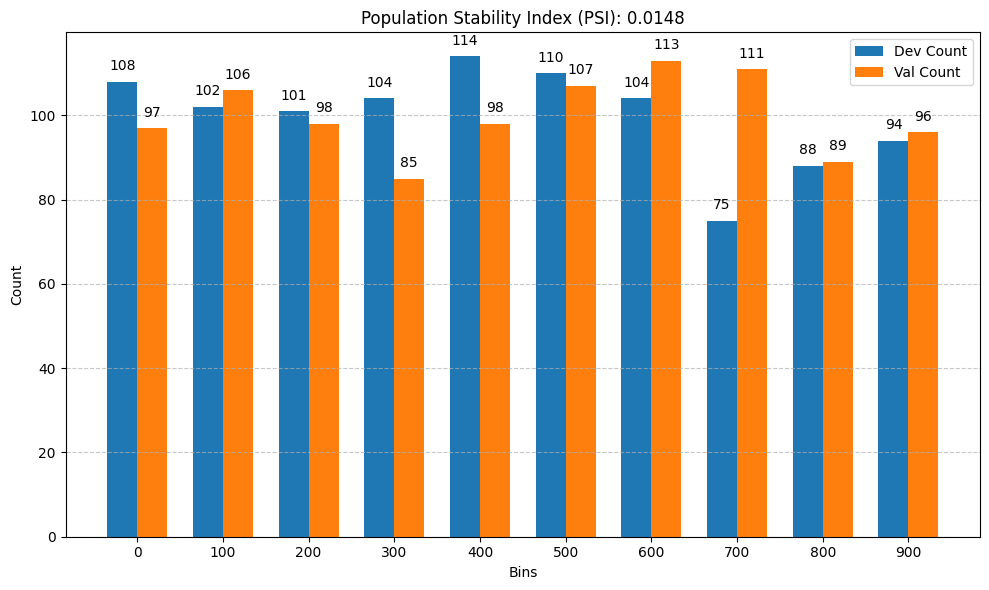

In [59]:
plot_psi(merged_counts, psi_value)